In [20]:
from PIL import Image
import numpy as np
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib notebook

In [21]:
landMaskIm = Image.open('land_mask.png').convert('LA')
realMapIm = Image.open('clean_map.png').convert('LA')
landMaskIm_flip = landMaskIm.transpose(Image.FLIP_LEFT_RIGHT)
realMapIm_flip = realMapIm.transpose(Image.FLIP_LEFT_RIGHT)

#realMapIm.show()

#landMaskIm.size

## Find squares of the land mask that have both water and land

In [22]:
npLMI = np.array(landMaskIm)[:,:,0]
npLMIF = np.array(landMaskIm_flip)[:,:,0]
npCMI = np.array(realMapIm)[:,:,0]
npCMIF = np.array(realMapIm_flip)[:,:,0]
#print(npLMI)
print(0 in npLMI, 255 in npLMI, 120 in npLMI)
print(npLMI.shape)
print(npCMI.shape)

True True False
(1015, 1831)
(1015, 1831)


In [23]:
nPics = 1000
subSquareSize = (52,52) # Must be multiple of 4!
maskSubSquares = np.zeros((nPics, subSquareSize[0], subSquareSize[1]))
realSubSquares = np.zeros((nPics, subSquareSize[0], subSquareSize[1]))
subSquareCoords = []
validSquareIndex = 0
while validSquareIndex < nPics:
    xCoord = np.random.randint(0,npLMI.shape[0]-subSquareSize[0])
    yCoord = np.random.randint(0,npLMI.shape[1]-subSquareSize[1])
    #print(xCoord, yCoord)
    candidateSubSquare = npLMI[xCoord:xCoord+subSquareSize[0],
                               yCoord:yCoord+subSquareSize[1]]
    if 50 < np.mean(candidateSubSquare) < 225:
        #print(candidateSubSquare.shape)
        #print(candidateSubSquare)
        subSquareCoords.append((xCoord, yCoord))
        maskSubSquare =  npLMI[xCoord:xCoord+subSquareSize[0],
                               yCoord:yCoord+subSquareSize[1]]
        maskSubSquares[validSquareIndex] = maskSubSquare
        
        realSubSquare =  npCMI[xCoord:xCoord+subSquareSize[0],
                               yCoord:yCoord+subSquareSize[1]]
        realSubSquares[validSquareIndex] = realSubSquare

        validSquareIndex += 1


## Check results of search

<IPython.core.display.Javascript object>


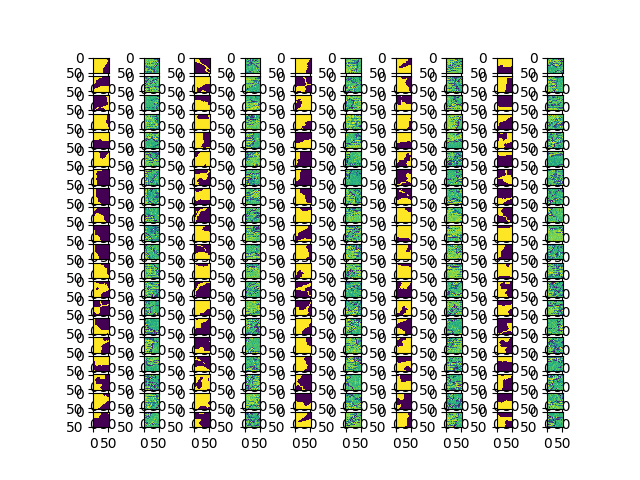

In [24]:
nPicsToShow = 100
nCols = 10
nRows = 2*(nPicsToShow+1) / (nCols)
for i in range(nPicsToShow):
    xCoord = subSquareCoords[i][0]
    yCoord = subSquareCoords[i][1]
    plt.subplot(nRows, nCols, (i*2)+1)
    #maskSubSquare = npLMI[xCoord:xCoord+subSquareSize[0],
    #                      yCoord:yCoord+subSquareSize[1]]
    plt.imshow(maskSubSquares[i])
    plt.subplot(nRows, nCols, (i*2)+2)
    #realSubSquare = npCMI[xCoord:xCoord+subSquareSize[0],
    #                      yCoord:yCoord+subSquareSize[1]]
    plt.imshow(realSubSquares[i])
#plt.tight_layout()
plt.show()

## Start machine learning

In [5]:
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU


Using TensorFlow backend.


In [6]:
X_train = maskSubSquares
Y_train = realSubSquares

# Scaling the range of the image to [-1, 1]
# Because we are using tanh as the activation function in the last layer of the generator
# and tanh restricts the weights in the range [-1, 1]
max_X = np.max(X_train)
factor = max_X / 2
X_train = (X_train - factor) / factor

max_Y = np.max(Y_train)
factor = max_X / 2
Y_train = (Y_train - factor) / factor

In [7]:
## Original
generator = Sequential([
        Dense((subSquareSize[0]/4)*(subSquareSize[1]/4)*16, input_dim=subSquareSize[0]*subSquareSize[1], activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Reshape((subSquareSize[0]/4,subSquareSize[0]/4,16)),
        UpSampling2D(),
        Convolution2D(8, (5, 5), padding='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        UpSampling2D(),
        Convolution2D(1, (5, 5), padding='same', activation='tanh')
    ])
generator.summary()

/Users/jeffreywagner/miniconda2/lib/python2.7/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2704)              7314320   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2704)              10816     
_________________________________________________________________
reshape_1 (Reshape)          (None, 13, 13, 16)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 8)         3208      
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 8)         32        
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 52, 52, 8)         0         
__________

In [15]:
generator = Sequential([
        #Dense((subSquareSize[0]/4)*(subSquareSize[1]/4)*16, input_dim=subSquareSize[0]*subSquareSize[1], activation=LeakyReLU(0.2)),
        #BatchNormalization(),
        Convolution2D(16, (5, 5), input_shape=(subSquareSize[0],subSquareSize[1],1), padding='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        #Reshape((subSquareSize[0]/4,subSquareSize[0]/4,1), input_shape=(subSquareSize[0]*subSquareSize[1],)),
        #UpSampling2D(),
        Convolution2D(8, (5, 5), padding='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        #UpSampling2D(),
        Convolution2D(1, (5, 5), padding='same', activation='tanh')
    ])
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 52, 52, 16)        416       
_________________________________________________________________
batch_normalization_5 (Batch (None, 52, 52, 16)        64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 8)         3208      
_________________________________________________________________
batch_normalization_6 (Batch (None, 52, 52, 8)         32        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 52, 52, 1)         201       
Total params: 3,921
Trainable params: 3,873
Non-trainable params: 48
_________________________________________________________________


In [16]:
discriminator = Sequential([
        Convolution2D(64, 5, 5, subsample=(2,2), input_shape=(subSquareSize[0],subSquareSize[1],1), border_mode='same', activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Convolution2D(128, 5, 5, subsample=(2,2), border_mode='same', activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 64)        1664      
_________________________________________________________________
dropout_3 (Dropout)          (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 128)       204928    
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21633     
Total params: 228,225
Trainable params: 228,225
Non-trainable params: 0
_________________________________________________________________


/Users/jeffreywagner/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same", strides=(2, 2), activation=<keras.lay..., input_shape=(52, 52, 1...)`
  
/Users/jeffreywagner/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same", strides=(2, 2), activation=<keras.lay...)`
  after removing the cwd from sys.path.


In [17]:
generator.compile(loss='binary_crossentropy', optimizer=Adam())

In [18]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

In [19]:
discriminator.trainable = False
ganInput = Input(shape=(subSquareSize[0], subSquareSize[1]))
# getting the output of the generator
# and then feeding it to the discriminator
# new model = D(G(input))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(input=ganInput, output=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

IndexError: list index out of range

In [13]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2704)              0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 52, 52, 1)         7328577   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 228225    
Total params: 7,556,802
Trainable params: 7,323,153
Non-trainable params: 233,649
_________________________________________________________________


In [14]:
def train(epoch=10, batch_size=128):
    batch_count = X_train.shape[0] // batch_size
    
    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Input for the generator
            #noise_input = np.random.rand(batch_size, 100)
            
            # getting random images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch_indices = np.random.randint(0, X_train.shape[0], size=batch_size)
            mask_image_batch = np.zeros((batch_size, subSquareSize[0]*subSquareSize[1]))
            for i in range(batch_size):
                mask_image_batch[i] = X_train[image_batch_indices[i],:,:].flatten()
            #mask_image_batch = X_train[image_batch_indices]
            #print('mask_image_batch.shape', mask_image_batch.shape)
            real_image_batch = np.zeros((batch_size, subSquareSize[0], subSquareSize[1], 1))
            real_image_batch[:,:,:,0] = Y_train[image_batch_indices]
            
            # these are the predicted images from the generator
            predictions = generator.predict(mask_image_batch, batch_size=batch_size)#[:,:,:,0]
            
            # the discriminator takes in the real images and the generated images
            #print(predictions.shape, real_image_batch.shape)
            X = np.concatenate([predictions, real_image_batch])
            
            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size
            
            # Let's train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_discriminator)
            
            # Let's train the generator
            #noise_input = np.random.rand(batch_size, 100)
            image_batch_indices = np.random.randint(0, X_train.shape[0], size=batch_size)
            mask_image_batch_2 = np.zeros((batch_size, subSquareSize[0]*subSquareSize[1]))
            y_generator = [1]*batch_size
            discriminator.trainable = False
            gan.train_on_batch(mask_image_batch_2, y_generator)

In [19]:
train(30, 128)

  0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'int' object has no attribute 'shape'

In [17]:
def plot_output():
    try_input = (np.random.rand(100,subSquareSize[0]*subSquareSize[1]))
    #try_input = np.zeros((100,100)) + 1
    #try_input[30:70,:] += 1.5
    #try_input[70:100,:] += 2.5
    #try_input = np.array(try_input)
    preds = generator.predict(try_input)
    #preds = generator.predict(np.array([[1]*10,2,2,2,3,3,3]))
    plt.clf()
    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    #plt.tight_layout()

<IPython.core.display.Javascript object>


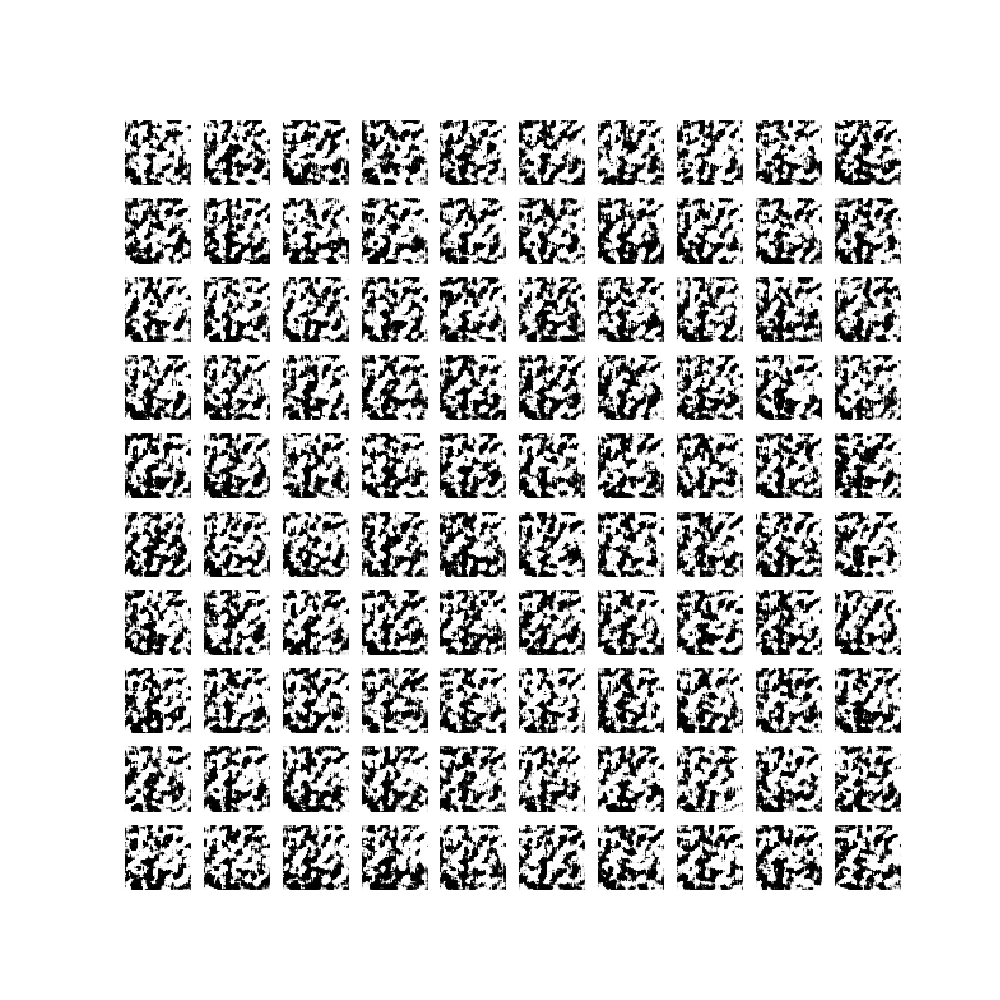

In [18]:
plot_output()